In [1]:
!pip install azure-storage-blob azure-identity --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 10.9 MB/s eta 0:00:00


In [2]:
import os
import time
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from azure.storage.blob import BlobServiceClient
from google.colab import userdata
import numpy as np
import cv2

# Authentication details
account_name = userdata.get('storage_account_name')
account_key = userdata.get('storage_account_key')
container_name = userdata.get('blob_container_name')

# Connection string to Azure Blob Storage
connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"

# Setup to load file from blob
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

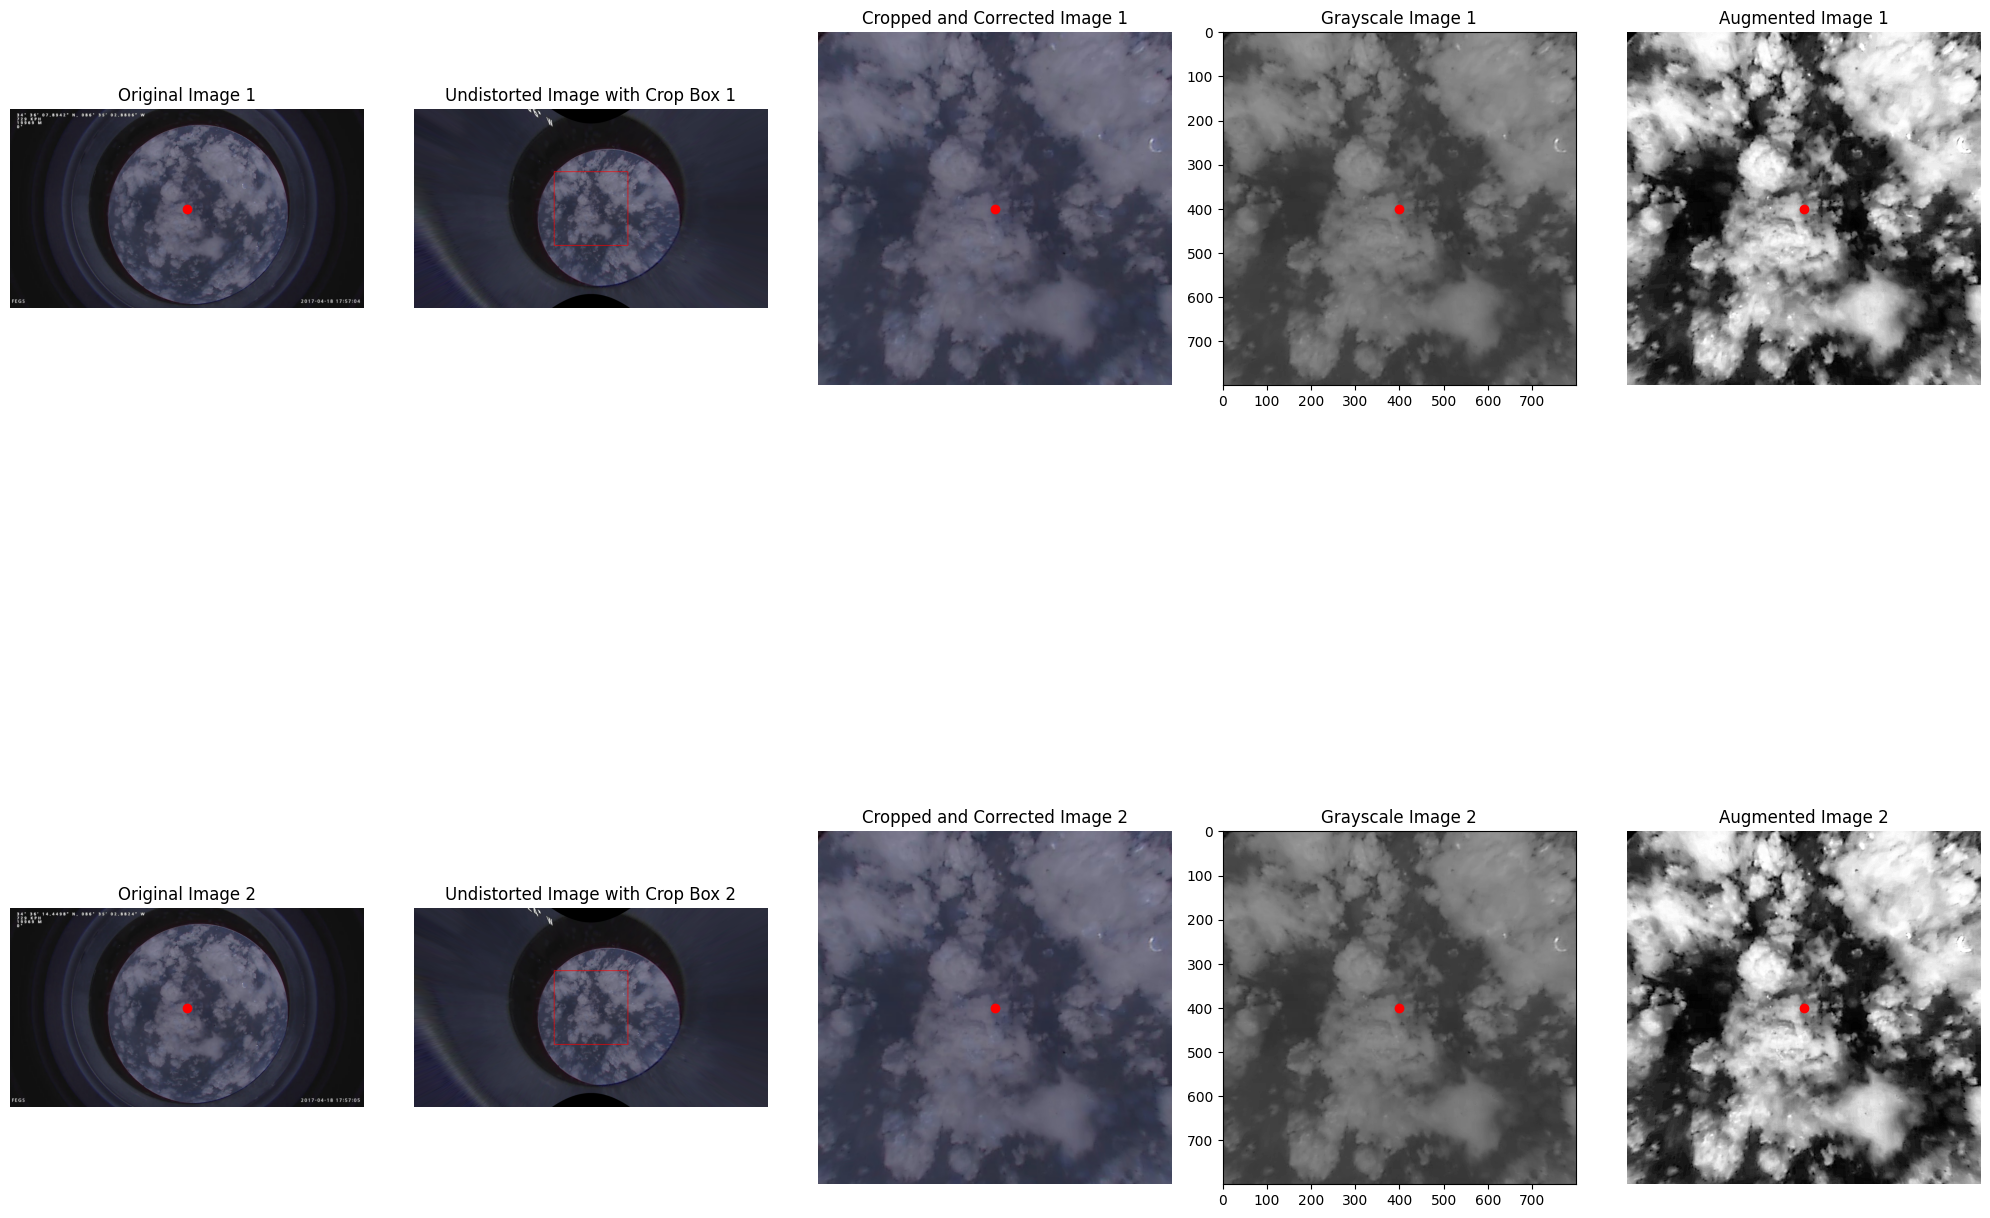

In [ ]:
originals = [
    "20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg",
    "20170418/170418_175706_183328_frames/20170418_175707_frame_60.jpg",
    # "20170418/170418_175706_183328_frames/20170418_175708_frame_120.jpg",
    # "20170418/170418_175706_183328_frames/20170418_175709_frame_180.jpg",
    # "20170418/170418_175706_183328_frames/20170418_175710_frame_240.jpg"
]

original_images = [load_image_from_blob_cv(original, container_client) for original in originals]
fisheye_crr_images = [undistort_fisheye_image(original_image) for original_image in original_images]
crop_corrected_images = [crop_and_correct_image_cv2(corrected_image) for corrected_image in fisheye_crr_images]
grey_scale_images = [cv2.cvtColor(crop_corr_image, cv2.COLOR_RGB2GRAY) for crop_corr_image in crop_corrected_images]
augmented_images = [augment_greyscale_image(grey_scale_image, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5)) for grey_scale_image in grey_scale_images]

fig, axes = plt.subplots(len(originals), 5, figsize=(20, 20))

for i, (original_image, fisheye_image, corrected_image, grey_scale_image, augmented_image) in enumerate(zip(original_images, fisheye_crr_images, crop_corrected_images, grey_scale_images, augmented_images)):
    fisheye_image_with_box = draw_crop_box_on_image2(fisheye_image)

    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].plot(960, 540, 'ro')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(fisheye_image_with_box)
    # axes[i, 1].imshow(fisheye_image)
    axes[i, 1].set_title(f'Undistorted Image with Crop Box {i+1}')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(corrected_image)
    axes[i, 2].plot(400, 400, 'ro')
    axes[i, 2].set_title(f'Cropped and Corrected Image {i+1}')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(grey_scale_image, cmap='gray')
    axes[i, 3].plot(400, 400, 'ro')
    axes[i, 3].set_title(f'Grayscale Image {i+1}')
    axes[i, 2].axis('off')

    axes[i, 4].imshow(augmented_image, cmap='gray')
    axes[i, 4].plot(400, 400, 'ro')
    axes[i, 4].set_title(f'Augmented Image {i+1}')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

In [3]:
!pwd

/content


In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/harvard.dce.nasa.cloud2cloud/capstone_2024/raw_data_processing

Mounted at /content/drive
/content/drive/MyDrive/harvard.dce.nasa.cloud2cloud/capstone_2024/raw_data_processing


In [5]:
import resize_crops as rc

In [ ]:
# , "170418_213438_221103_frames", "170418_221104_224729_frames", "70418_224730_230811_frames", "170418_175706_183328_frames", "170418_183329_190941_frames",
# "170418_190942_194550_frames", "170418_194551_202218_frames", "170418_202220_205829_frames", "70418_205830_213437_frames"
    # "20170422": ["170422_203040_210703_frames", "170422_210704_212527_frames", "170422_212816_215538_frames", "170422_215914_223549_frames",
    #              "170422_223550_231158_frames", "170422_231159_234813_frames"],
    # "20170508": ["170508_202828_210445_frames", "170508_210445_214120_frames", "170508_214121_221716_frames", "170508_221717_222313_frames",
    #               "170508_222527_230134_frames", "170508_230135_233759_frames", "170508_233759_234800_frames", "170508_235024_002714_frames",
    #               "170509_002715_010315_frames", "170509_010315_014103_frames"],
    # "170512_160457_164101_frames", "170512_164101_171715_frames", "170512_171715_174505_frames",
    # "20170512": ["170512_174750_182409_frames",
    #              "170512_182410_190033_frames", "170512_190034_193656_frames", "170512_193656_201305_frames", "170512_201305_204918_frames"],
    # "20170514": ["170514_115518_123118_frames", "170514_123119_130737_frames", "170514_130738_134329_frames", "170514_134330_141925_frames",
    #              "170514_141926_145510_frames", "170514_145511_153106_frames", "170514_153107_160701_frames", "170514_160702_164305_frames",
    #              "170514_164305_171917_frames"]

In [ ]:
import os

flight_list = {
    "60fps_v1/20170418": ["170418_175706_183328_frames"],
}

from tqdm import tqdm

for flight, frame_folders in tqdm(flight_list.items(), desc="Flights"):
    for dir in tqdm(frame_folders, desc=f"Processing {flight}", leave=False):
        st = time.time()
        src = flight + '/' + dir + '/'
        print(src)
        dest = src.replace('_frames', '_frames_crop_corrected_aligned')
        print(dest)
        print(f"Starting cropping for {src} -> {dest}")
        rc.crop_and_correct_images_in_blob(container_client, src, dest, print_cnts=False)
        et = time.time()
        tt = round((et - st)/60, 2)
        print(f"Completed cropping for {src} -> {dest} in {tt} mins.")

Processing 60fps_v1/20170418:   0%|          | 0/1 [00:00<?, ?it/s]

60fps_v1/20170418/170418_175706_183328_frames/
60fps_v1/20170418/170418_175706_183328_frames_crop_corrected_aligned/
Starting cropping for 60fps_v1/20170418/170418_175706_183328_frames/ -> 60fps_v1/20170418/170418_175706_183328_frames_crop_corrected_aligned/


In [ ]:
# Function to load the first image found in the blob storage
def load_first_image(container_client, src):
    blobs = container_client.list_blobs(name_starts_with=src)
    for blob in blobs:
        if '_frames_cropped' in blob.name and blob.name.endswith('.jpg'):
            print(f"Found image: {blob.name}")
            blob_client = container_client.get_blob_client(blob.name)
            img_stream = BytesIO(blob_client.download_blob().readall())
            return img_stream, blob.name
    return None, None

# Function to crop to square with varying reduction factors
def crop_to_square(image_stream, reduction_factor=0.1, offset_factor=0.0):
    """
    Crops the input image to a square format focusing on the center to exclude the lens boundary.

    Args:
        image_stream (BytesIO): The image in memory.

    Returns:
        PIL.Image: Cropped image.
    """
    img = Image.open(image_stream)

    width, height = img.size
    reduce_amount = int(min(width, height) * reduction_factor)
    new_size = min(width, height) - 2 * reduce_amount

    offset = int(width * offset_factor)

    left = (width - new_size) / 2 + offset
    top = (height - new_size) / 2
    right = (width + new_size) / 2 + offset
    bottom = (height + new_size) / 2

    img_cropped = img.crop((left, top, right, bottom))
    return img_cropped

# Function to save the cropped image back to Azure Blob Storage
def save_cropped_image(container_client, cropped_img, src_blob_name, dest):
    """
    Saves the cropped image to Azure Blob Storage with a modified folder name.

    Args:
        container_client (azure.storage.blob.ContainerClient): Azure blob storage container client
        cropped_img (PIL.Image): Cropped image.
        src_blob_name (str): Source blob name.
        dest (str): The folder where cropped images will be saved.

    Returns:
        None
    """
    img_byte_array = BytesIO()
    cropped_img.save(img_byte_array, format='JPEG')
    img_byte_array.seek(0)

    base_name = os.path.basename(src_blob_name)
    cropped_blob_name = os.path.join(dest, base_name)

    blob_client = container_client.get_blob_client(cropped_blob_name)
    blob_client.upload_blob(img_byte_array, overwrite=True)
    #print(f"Cropped image uploaded to: {cropped_blob_name}")

# Function to crop images in the blob storage
def crop_images_in_blob(container_client, src, dest):
    """
    Reads images from src dir in an azure blob, applies crop_to_square,
    and uploads cropped images to dest dir in the same blob.

    Args:
        container_client (azure.storage.blob.ContainerClient): azure blob storage container client
        src (str): path to the dir containing src images.
        dest (str): path to the dir with cropped images.

    Returns:
        (str): path to the cropped images directory.
    """
    blobs = container_client.list_blobs(name_starts_with=src)
    existing_blobs = {blob.name for blob in container_client.list_blobs(name_starts_with=dest)}
    for blob in blobs:
        if blob.name.endswith('.jpg'):
            base_name = os.path.basename(blob.name)
            new_filename = base_name.replace('.jpg', '_cropped.jpg')
            cropped_blob_name = os.path.join(dest, new_filename)
            if cropped_blob_name in existing_blobs:
                continue

            blob_client = container_client.get_blob_client(blob.name)
            img_stream = BytesIO(blob_client.download_blob().readall())

            # 0.07 as chosen by examples below
            cropped_img = crop_to_square(img_stream, 0.074, 0)

            save_cropped_image(container_client, cropped_img, blob.name, dest)
    return dest

Found image: 20170418/170418_175706_183328_frames_cropped/20170418_175706_frame_0_cropped.jpg


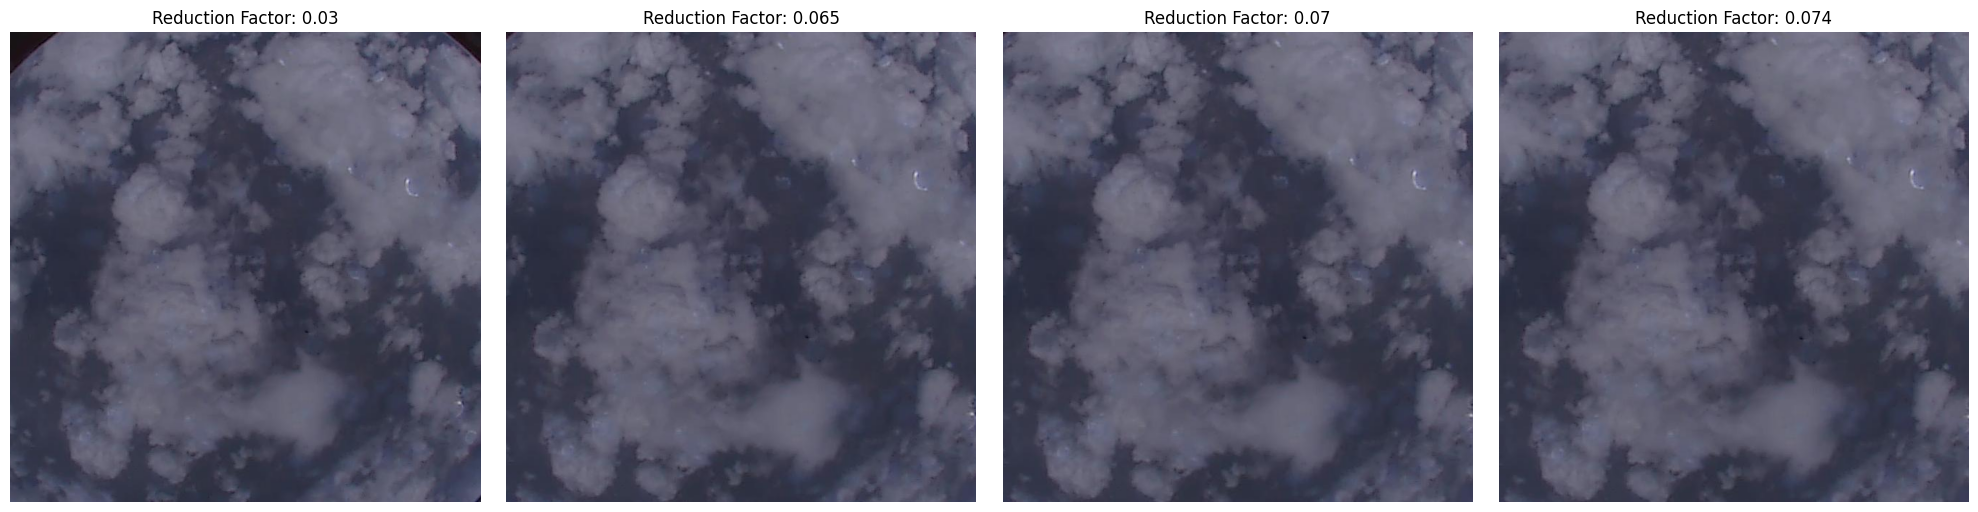

In [ ]:
# Load the first image
src_directories = ["20170418", "20170422", "20170508", "20170512"]
img_stream, blob_name = None, None
for src_directory in src_directories:
    img_stream, blob_name = load_first_image(container_client, src_directory + '/')
    if img_stream:
        break

# Apply crop_to_square with different reduction factors
if img_stream:
    reduction_factors = [0.03, 0.065, 0.07, 0.074]
    cropped_images = [crop_to_square(BytesIO(img_stream.getvalue()), rf) for rf in reduction_factors]

    # Display the images in a grid
    fig, axes = plt.subplots(1, len(cropped_images), figsize=(20, 5))
    for ax, img, rf in zip(axes, cropped_images, reduction_factors):
        ax.imshow(img)
        ax.set_title(f'Reduction Factor: {rf}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No images found in the specified directory.")

In [ ]:
# Iterate through the entire blob and crop all matching files
flight_list = ["20170418", "20170422", "20170508", "20170512"]
for flight in flight_list:
    blobs = container_client.list_blobs(name_starts_with=flight)
    frame_folders = set()
    for blob in blobs:
        dir = os.path.dirname(blob.name)
        if dir.endswith('frames_cropped') and dir not in frame_folders:
            frame_folders.add(dir)

    for dir in frame_folders:
        st = time.time()
        src = dir + '/'
        dest = src.replace('frames_cropped', 'frames_tight_crop')
        crop_images_in_blob(container_client, src, dest)
        et = time.time()
        tt = round((et - st)/60, 2)
        print(f"Completed cropping for {src} -> {dest} in {tt} mins.")

Completed cropping for 20170418/170418_224730_230811_frames_cropped/ -> 20170418/170418_224730_230811_frames_tight_crop/ in 3.07 mins.
Completed cropping for 20170418/170418_183329_190941_frames_cropped/ -> 20170418/170418_183329_190941_frames_tight_crop/ in 5.37 mins.
Completed cropping for 20170418/170418_202220_205829_frames_cropped/ -> 20170418/170418_202220_205829_frames_tight_crop/ in 5.66 mins.
Completed cropping for 20170418/170418_194551_202218_frames_cropped/ -> 20170418/170418_194551_202218_frames_tight_crop/ in 5.72 mins.
Completed cropping for 20170418/170418_205830_213437_frames_cropped/ -> 20170418/170418_205830_213437_frames_tight_crop/ in 5.55 mins.
Completed cropping for 20170418/170418_213438_221103_frames_cropped/ -> 20170418/170418_213438_221103_frames_tight_crop/ in 5.83 mins.
Completed cropping for 20170418/170418_190942_194550_frames_cropped/ -> 20170418/170418_190942_194550_frames_tight_crop/ in 6.12 mins.
Completed cropping for 20170418/170418_221104_224729_fr